<a href="https://colab.research.google.com/github/Nagy127/KaggleX2024/blob/main/KaggleX_Skill_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Description

The dataset for the competition contains 12 columns, each described in the table below.

Each row represents a unique vehicle listing

| Column       | Description                                                                                          |
| ------------ | ---------------------------------------------------------------------------------------------------- |
| Id         | id number given to each. car                                                                              |
| Brand         | Car brand.                                                                                       |
| Model        | Car model.                                                                                            |
| Model year         | the manufacturing year of the vehicles. |
| Mileage | mileage of each vehicle, distance traveled by the vehicle since manufacturing in miles.             |
| Fuel Type          | the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.                  |
| Engine        | the engine specifications, shedding light on performance and efficiency.                                                            |
| Transmission    | the transmission type, whether automatic, manual, or another variant.|
| Exterior color     | Exterior color options.                                |
| Interior color        | interior color options.                                                                            |
| Accident     | whether a vehicle has a prior history of accidents or damage.                                                                            |
| Clean title       | the availability of a clean title.                                                                  |
| Price       | listed prices for each vehicle.                                                                  |

Highest scores achieved were 76379 RMSE of LGB, XGB second best with 76431 on the public leaderboard. On the private leaderboard, the score achieved was 70192 which ranks 567th out of 1850 entries.

# Importing libraries and datasets

In [ ]:
import math, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import io
from google.colab import files

  Secondly, we upload the datasets from Kaggle.

In [ ]:
! pip install kaggle

Uploading kaggle key

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c kagglex-cohort4

  0% 0.00/2.17M [00:00<?, ?B/s]
100% 2.17M/2.17M [00:00<00:00, 170MB/s]


In [ ]:
!unzip kagglex-cohort4

Archive:  kagglex-cohort4.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


# Data inspection

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54273 non-null  int64 
 1   brand         54273 non-null  object
 2   model         54273 non-null  object
 3   model_year    54273 non-null  int64 
 4   milage        54273 non-null  int64 
 5   fuel_type     54273 non-null  object
 6   engine        54273 non-null  object
 7   transmission  54273 non-null  object
 8   ext_col       54273 non-null  object
 9   int_col       54273 non-null  object
 10  accident      54273 non-null  object
 11  clean_title   54273 non-null  object
 12  price         54273 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.4+ MB


In [ ]:
train_df.describe(include='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,54273.000000,54273,54273,54273.000000,54273.000000,54273,54273,54273,54273,54273,54273,54273,5.427300e+04
unique,NaN,53,1827,NaN,NaN,7,1061,46,260,124,2,1,NaN
top,NaN,BMW,F-150 XLT,NaN,NaN,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,7369,780,NaN,NaN,49439,1452,16757,15078,31820,39896,54273,NaN
mean,27136.000000,NaN,NaN,2015.091979,72746.175667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.921844e+04
std,15667.409917,NaN,NaN,5.588909,50469.490448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.282634e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,13568.000000,NaN,NaN,2012.000000,32268.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.550000e+04
50%,27136.000000,NaN,NaN,2016.000000,66107.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.800000e+04
75%,40704.000000,NaN,NaN,2019.000000,102000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000e+04


In [ ]:
train_df.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [ ]:
for column in train_df.columns:
    print(f"{column} : {train_df[column].unique()}")
    print("====================================")

id : [    0     1     2 ... 54270 54271 54272]
brand : ['Ford' 'BMW' 'Jaguar' 'Pontiac' 'Acura' 'Audi' 'GMC' 'Maserati'
 'Chevrolet' 'Porsche' 'Mercedes-Benz' 'Tesla' 'Lexus' 'Kia' 'Lincoln'
 'Dodge' 'Volkswagen' 'Land' 'Cadillac' 'Mazda' 'RAM' 'Subaru' 'Hyundai'
 'MINI' 'Jeep' 'Honda' 'Hummer' 'Nissan' 'Toyota' 'Volvo' 'Genesis'
 'Mitsubishi' 'Buick' 'INFINITI' 'McLaren' 'Scion' 'Lamborghini' 'Bentley'
 'Suzuki' 'Ferrari' 'Alfa' 'Rolls-Royce' 'Chrysler' 'Aston' 'Rivian'
 'Lotus' 'Saturn' 'Lucid' 'Mercury' 'Maybach' 'FIAT' 'Plymouth' 'Bugatti']
model : ['F-150 Lariat' '335 i' 'XF Luxury' ... 'Q4 e-tron Sportback Premium'
 'Countryman Cooper' 'S-10 LS']
model_year : [2018 2007 2009 2022 2001 2003 2014 2019 2016 2017 2013 2021 2015 2020
 2012 2006 2023 2011 2010 1999 2004 1993 2002 2005 2008 1995 1998 2000
 1997 1994 1996 2024 1992 1974]
milage : [74349 80000 91491 ... 62850 82984 28750]
fuel_type : ['Gasoline' 'Hybrid' 'E85 Flex Fuel' 'Diesel' '–' 'Plug-In Hybrid'
 'not supported']
engi

In [ ]:
for column in train_df.columns:
    print(f"{column}: Number of unique values {train_df[column].nunique()}")
    print("==========================================================")

id: Number of unique values 54273
brand: Number of unique values 53
model: Number of unique values 1827
model_year: Number of unique values 34
milage: Number of unique values 3212
fuel_type: Number of unique values 7
engine: Number of unique values 1061
transmission: Number of unique values 46
ext_col: Number of unique values 260
int_col: Number of unique values 124
accident: Number of unique values 2
clean_title: Number of unique values 1
price: Number of unique values 1481


In [ ]:
train_df['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

In [ ]:
train_df['transmission'].value_counts()

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

In [ ]:
train_df[train_df['ext_col'] == '–'].shape

(41, 13)

In [ ]:
train_df[train_df['int_col'] == '–'].shape

(1045, 13)

In [ ]:
train_df[train_df['engine'] == '-'].shape

(335, 13)

# Data pre-processing and cleaning

First we remove the unimportant colemns to our analysis.

In [ ]:
train_df.drop(['id','clean_title'], axis=1, inplace=True)
train_df.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,8250
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,15000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,63500
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,7850


Second, we replace accident column from string to binary and remove/impute missing values.

In [ ]:
train_df['accident']=train_df['accident'].replace(['None reported' , 'At least 1 accident or damage reported'],[0,1])
train_df['accident'].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
54268    0
54269    1
54270    1
54271    0
54272    0
Name: accident, Length: 54273, dtype: int64

In [ ]:
train_df["int_col"]=train_df["int_col"].replace("-",train_df["int_col"].mode()[0])
train_df["int_col"]=train_df["int_col"].replace("not supported",train_df["int_col"].mode()[0])
train_df["int_col"]

0         Gray
1        Black
2        Beige
3        Brown
4        Black
         ...  
54268    Brown
54269    Black
54270    Black
54271    Brown
54272    Black
Name: int_col, Length: 54273, dtype: object

In [ ]:
train_df["transmission"] = train_df["transmission"].replace("–",np.nan)

In [ ]:
train_df["ext_col"] = train_df["ext_col"].replace("–",np.nan)

In [ ]:
train_df["fuel_type"] = train_df["fuel_type"].replace("–",np.nan)

In [ ]:
train_df["engine"] = train_df["engine"].replace("–",np.nan)

In [ ]:
train_df.dropna(axis=0)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,0,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,0,8250
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,0,15000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,0,63500
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,0,7850
...,...,...,...,...,...,...,...,...,...,...,...
54268,BMW,X6 xDrive50i,2017,29000,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Brown,0,29000
54269,Audi,A4 2.0T Premium,2015,94634,E85 Flex Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Black,1,6500
54270,Porsche,Cayenne S,2013,40989,Gasoline,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,1,18950
54271,Porsche,911 Carrera 4 GTS,2023,1518,Gasoline,4.0L H6 24V GDI DOHC,8-Speed Automatic with Auto-Shift,Beige,Brown,0,194965


Finally, we extract the values from the engine column before dropping it.

In [ ]:
def extract_cylinders(description):
    pattern1 = r'\b(\d+)\s*cylinder\b'
    pattern2 = r'(\d+)\s*[Vv]\b'
    pattern3 = r'[Vv]\s*(\d+)\b'
    match1 = re.search(pattern1, description, re.IGNORECASE)
    match2 = re.search(pattern2, description, re.IGNORECASE)
    match3 = re.search(pattern3, description, re.IGNORECASE)
    if match1:
        return int(match1.group(1))
    if match2:
        return int(match2.group(1))
    if match3:
        return int(match3.group(1))

    return 0


hp=train_df['engine'].astype(str).apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
liters=train_df['engine'].astype(str).apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')
cylinder=train_df['engine'].astype(str).apply(extract_cylinders)

train_df['HP']=hp
train_df['liters']=liters
train_df['cylinders']=cylinder
train_df.drop(['engine'], axis=1, inplace=True)
train_df.head(5)

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,HP,liters,cylinders
0,Ford,F-150 Lariat,2018,74349,Gasoline,10-Speed A/T,Blue,Gray,0,11000,375.0,3.5,6
1,BMW,335 i,2007,80000,Gasoline,6-Speed M/T,Black,Black,0,8250,300.0,3.0,6
2,Jaguar,XF Luxury,2009,91491,Gasoline,6-Speed A/T,Purple,Beige,0,15000,300.0,4.2,8
3,BMW,X7 xDrive40i,2022,2437,Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,0,63500,335.0,3.0,6
4,Pontiac,Firebird Base,2001,111000,Gasoline,A/T,White,Black,0,7850,200.0,3.8,6


In [ ]:
train_df["HP"]=train_df["HP"].fillna(train_df['HP'].mean())
train_df["liters"]=train_df["liters"].fillna(train_df['liters'].mean())
train_df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       294
transmission      7
ext_col          41
int_col           0
accident          0
price             0
HP                0
liters            0
cylinders         0
dtype: int64

# Exploratory data analysis

We plot some graphs to see the relationship between some columns and the price of the car.

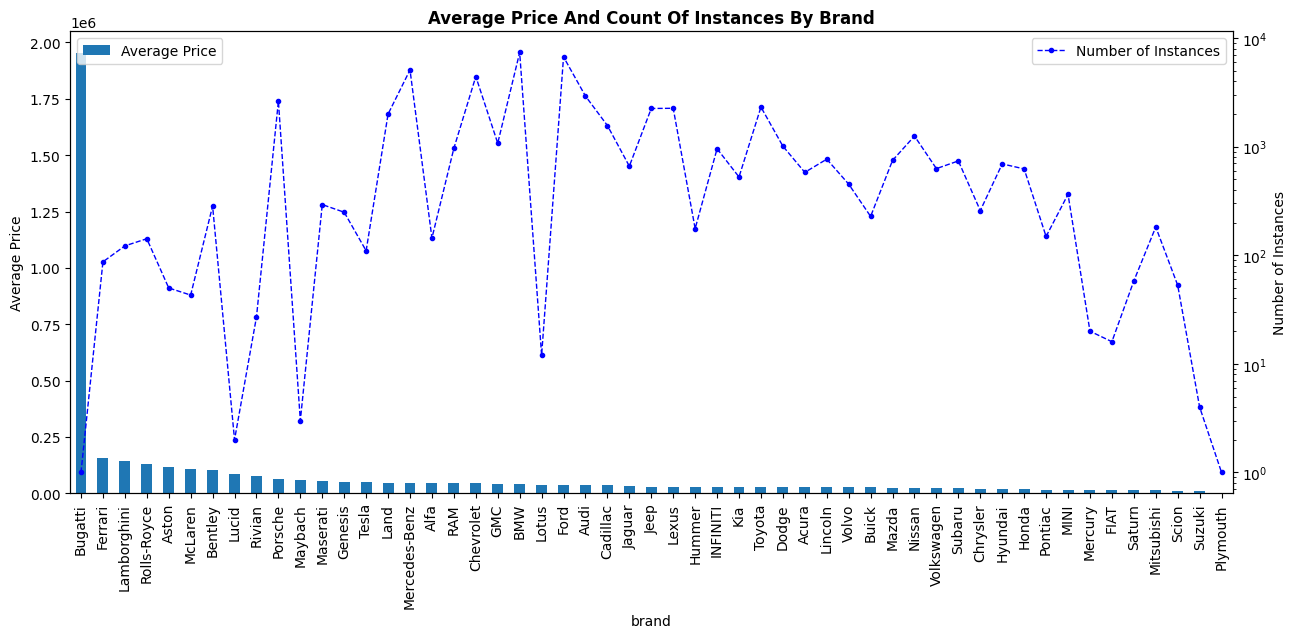

In [ ]:
g=train_df.groupby('brand').agg({'price':['mean','count']}).sort_values(('price','mean'),ascending=False)

fig,ax=plt.subplots(figsize=(15,6))
ax2=ax.twinx()
g.plot.bar(ax=ax,y=('price','mean'),label='Average Price')
g.plot.line(ax=ax2,y=('price','count'),color='blue',ls='--',lw=1,marker='.',label='Number of Instances')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax.set_title('Average Price And Count Of Instances By Brand',fontweight='bold')
ax.set_ylabel('Average Price')
ax2.set_ylabel('Number of Instances')
plt.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Gasoline'),
  Text(1, 0, 'Hybrid'),
  Text(2, 0, 'E85 Flex Fuel'),
  Text(3, 0, 'Diesel'),
  Text(4, 0, 'Plug-In Hybrid'),
  Text(5, 0, 'not supported')])

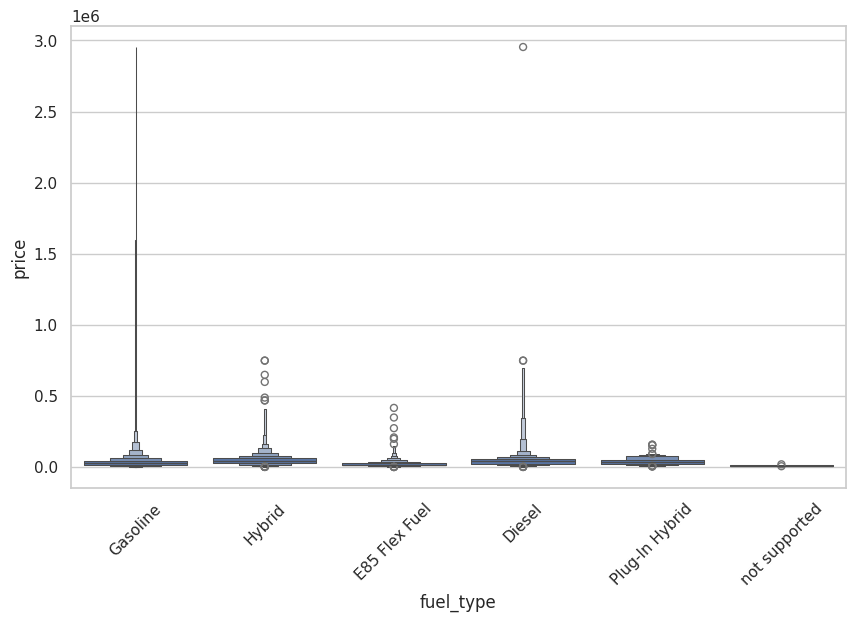

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxenplot(x = 'fuel_type', y = 'price', data =train_df)
plt.xticks(rotation=45)

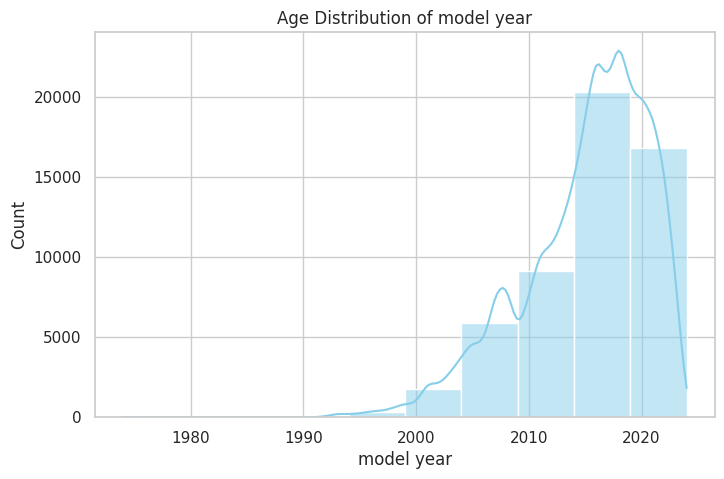

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=train_df, x='model_year', bins=10, kde=True, color='skyblue')
plt.title("Age Distribution of model year")
plt.xlabel("model year")
plt.ylabel("Count")
plt.show()

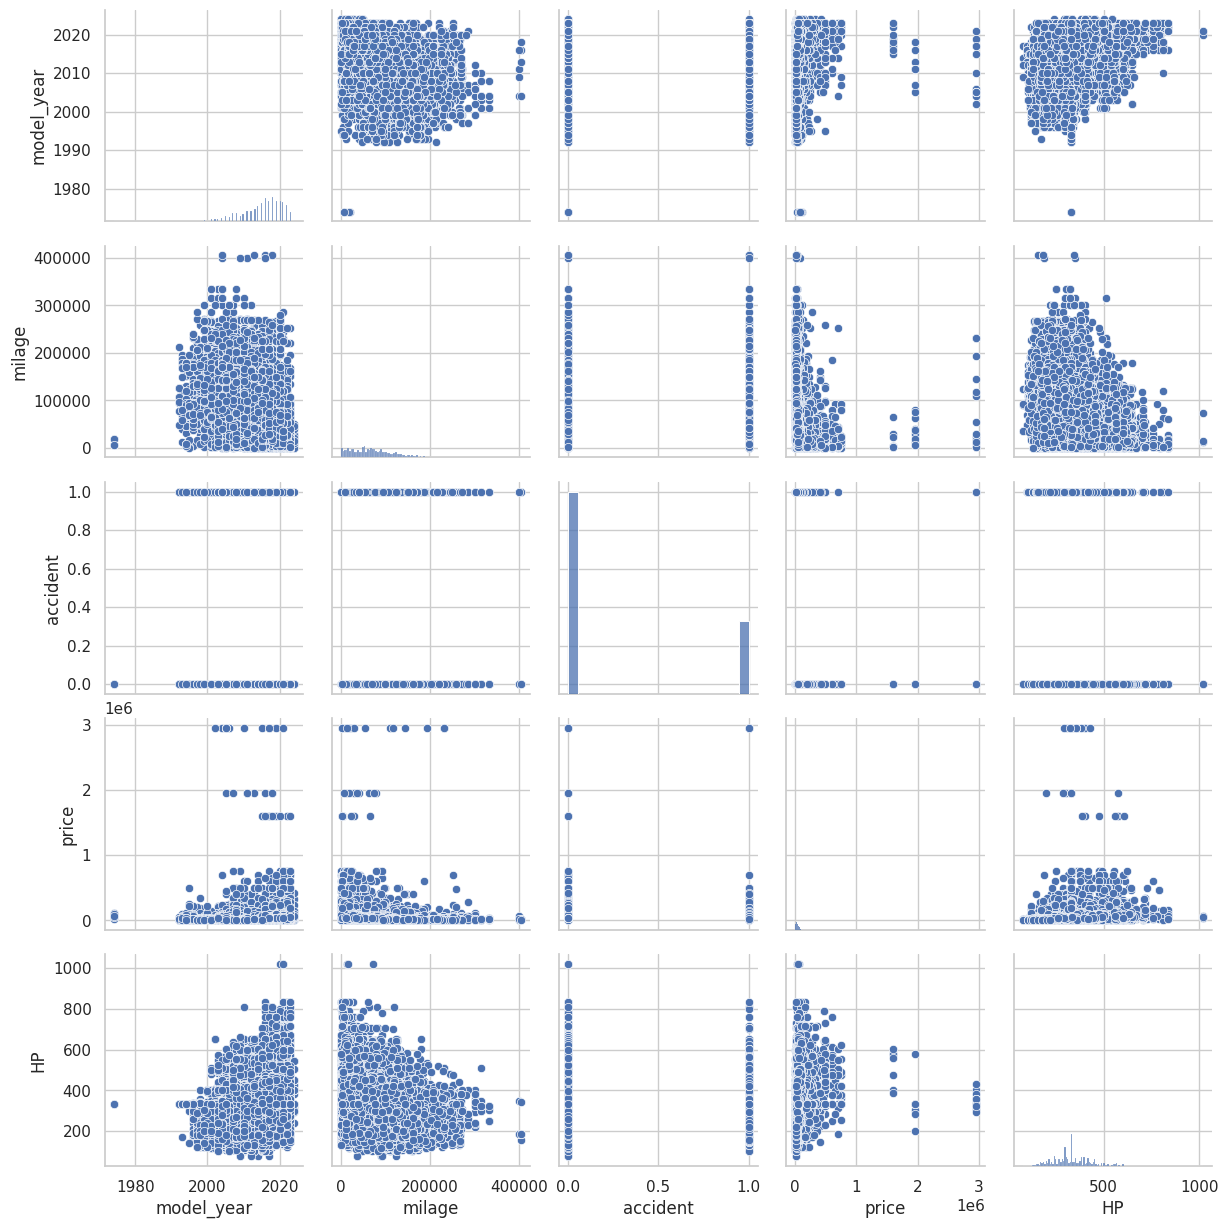

In [ ]:
sns.pairplot(train_df[['model_year','milage','accident','price','HP',]])

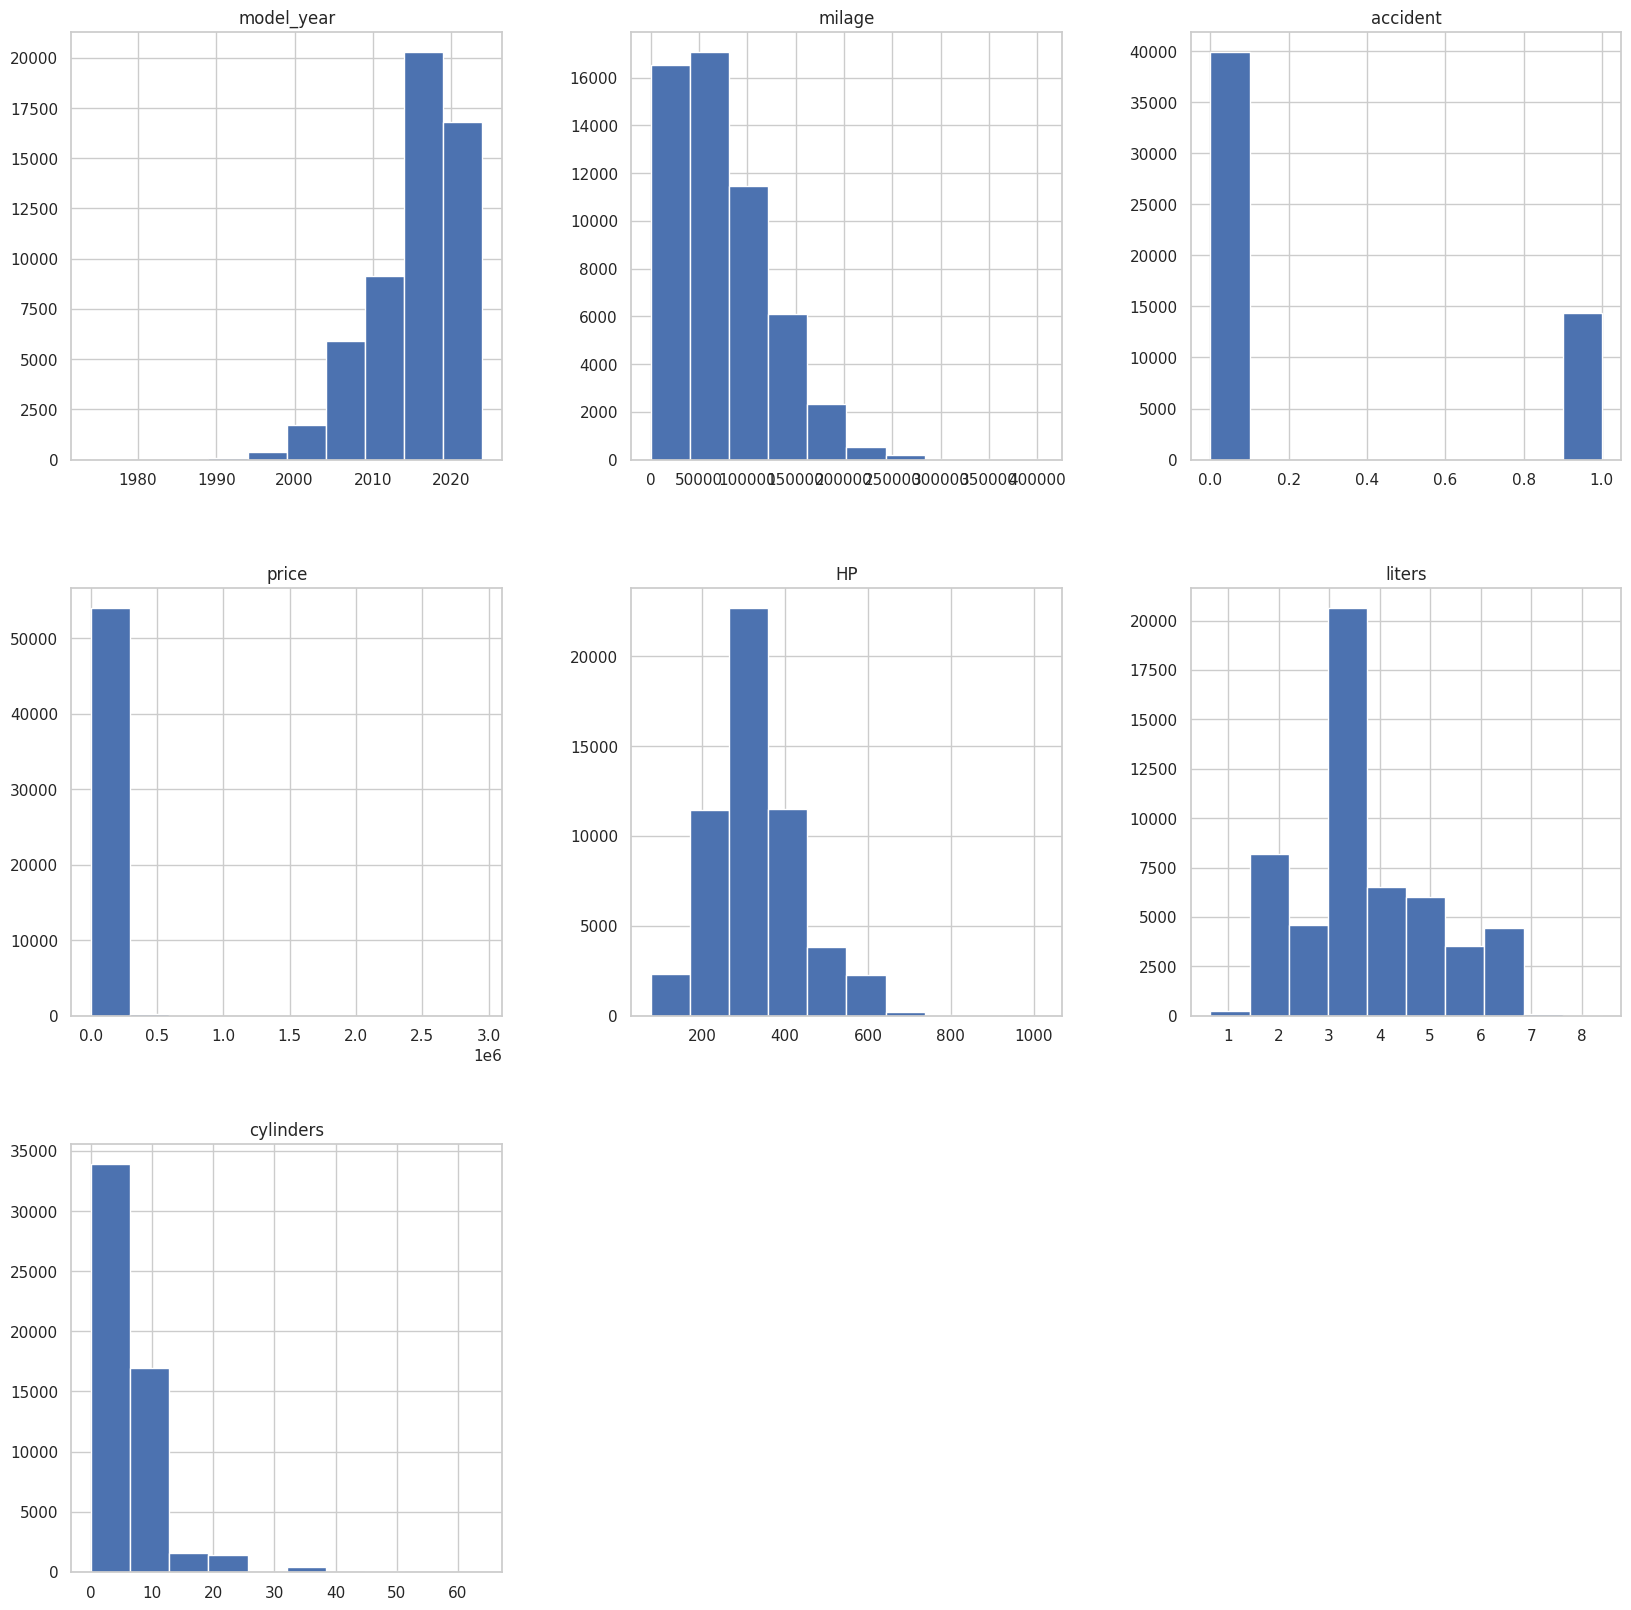

In [ ]:
train_df.hist(figsize=(20, 20));

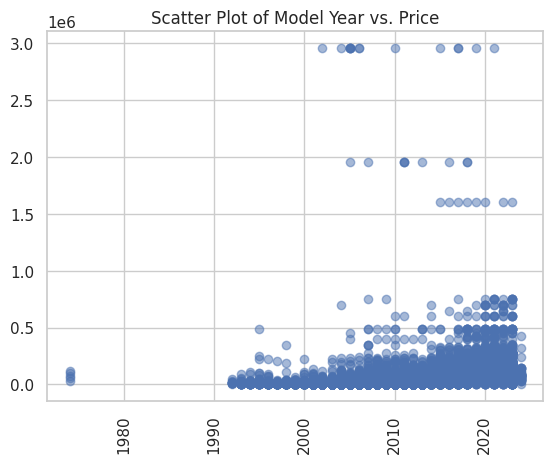

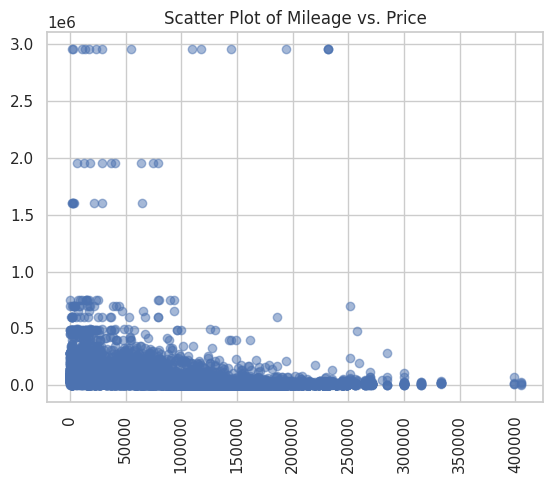

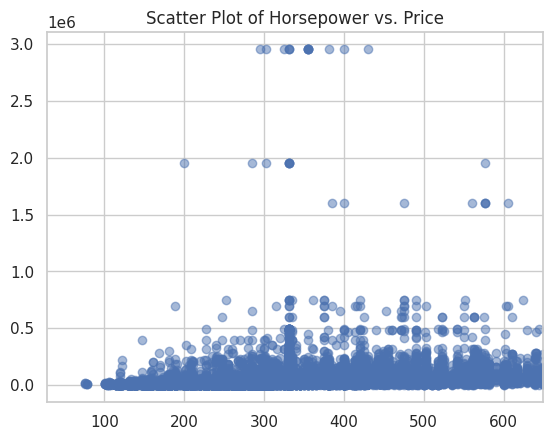

In [ ]:
plt.scatter(x=train_df['model_year'], y=train_df['price'], alpha=0.5)
plt.title('Scatter Plot of Model Year vs. Price')
plt.xticks(rotation=90)
plt.show()

plt.scatter(x=train_df['milage'], y=train_df['price'], alpha=0.5)
plt.title('Scatter Plot of Mileage vs. Price')
plt.xticks(rotation=90)
plt.show()

plt.scatter(x=train_df['HP'], y=train_df['price'], alpha=0.5)
plt.gca().set_xlim(right=650)
plt.title('Scatter Plot of Horsepower vs. Price')
plt.show()

# Data preparation for modelling

We perform label encoding on categorical columns with more than 2 unique values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

train_df['brand'] = labelEncoder.fit_transform(train_df['brand'])
train_df['model'] = labelEncoder.fit_transform(train_df['model'])
train_df['fuel_type'] = labelEncoder.fit_transform(train_df['fuel_type'])
train_df['transmission'] = labelEncoder.fit_transform(train_df['transmission'])
train_df['ext_col'] = labelEncoder.fit_transform(train_df['ext_col'])
train_df['int_col'] = labelEncoder.fit_transform(train_df['int_col'])

In [ ]:
train_df.describe()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,HP,liters,cylinders
count,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,5.427300e+04,54273.000000,54273.000000,54273.000000
mean,20.905994,890.403902,2015.091979,72746.175667,1.993017,26.693789,124.015901,23.891382,0.264902,3.921844e+04,331.698323,3.716928,7.221583
std,14.796166,541.872180,5.588909,50469.490448,0.492170,11.319567,97.411242,30.436187,0.441285,7.282634e+04,103.936245,1.328719,4.565070
min,0.000000,0.000000,1974.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+03,76.000000,0.650000,0.000000
25%,9.000000,452.000000,2012.000000,32268.000000,2.000000,18.000000,17.000000,9.000000,0.000000,1.550000e+04,261.000000,3.000000,6.000000
50%,17.000000,829.000000,2016.000000,66107.000000,2.000000,28.000000,100.000000,9.000000,0.000000,2.800000e+04,329.000000,3.500000,6.000000
75%,35.000000,1377.000000,2019.000000,102000.000000,2.000000,34.000000,249.000000,24.000000,1.000000,4.500000e+04,395.000000,4.600000,8.000000
max,52.000000,1826.000000,2024.000000,405000.000000,6.000000,45.000000,259.000000,123.000000,1.000000,2.954083e+06,1020.000000,8.400000,64.000000


We normalize the price column, then split the training data 80/20.

In [ ]:
mean = train_df['price'].mean(axis=0)
train_df['price'] -= mean
std = train_df['price'].std(axis=0)
train_df['price'] /= std

In [ ]:
X = train_df.drop('price', axis=1)
y = train_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Data modelling

The following code is done to determine the best models with default parameters to be able to choose the best models to optimize.

In [ ]:
def Training(model, X_train, X_test, y_train, y_test):
    model = model()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    return error

In [ ]:
rf_error = Training(RandomForestRegressor, X_train, X_test, y_train, y_test)
rf_error

0.3591512326101437

In [ ]:
hb_error = Training(HuberRegressor, X_train, X_test, y_train, y_test)
hb_error

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.4891006225004134

In [ ]:
lr_error = Training(LinearRegression, X_train, X_test, y_train, y_test)
lr_error

0.4265463983583286

In [ ]:
dt_error = Training(DecisionTreeRegressor, X_train, X_test, y_train, y_test)
dt_error

0.6977191905109592

In [ ]:
ab_error = Training(AdaBoostRegressor, X_train, X_test, y_train, y_test)
ab_error

0.5249515188806652

In [ ]:
gb_error = Training(GradientBoostingRegressor, X_train, X_test, y_train, y_test)
gb_error

0.3485049975484712

The first model we are going to utilize is Linear regression

In [ ]:
lr_model = LinearRegression().fit(X_train,y_train)

In [ ]:
predictions = lr_model.predict(X_test)
error = mean_squared_error(y_test, predictions)
error

0.4265463983583286

The second is Gradient Boost Regressor

In [ ]:
GBR_model = GradientBoostingRegressor(n_estimators=80 , learning_rate=0.01).fit(X_train, y_train)

In [ ]:
predictions = GBR_model.predict(X_test)
error = mean_squared_error(y_test, predictions)
error

0.5347454063235592

The third is Random Forest Regressor

In [ ]:
RF_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)

In [ ]:
predictions = RF_model.predict(X_test)
error = mean_squared_error(y_test, predictions)
error

0.3438028717670077

## XG Boost regressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
XG_model = XGBRegressor(n_estimators=500, eta=0.4)
XG_model.fit(X_train, y_train,
             early_stopping_rounds=5,
             eval_set=[(X_test, y_test)],
             verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
predictions = XG_model.predict(X_test)
print("Mean squared Error: " + str(mean_squared_error(predictions, y_test)))

Mean squared Error: 0.3436514319659845


## SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVR, LinearSVR

In [ ]:
svr_rbf = LinearSVR(C=1e3)

svr_rbf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1000.0)

In [ ]:
y_pred = svr_rbf.predict(X_test)

MSE = np.mean(np.square(y_test - y_pred))
MSE

4.314575713307998

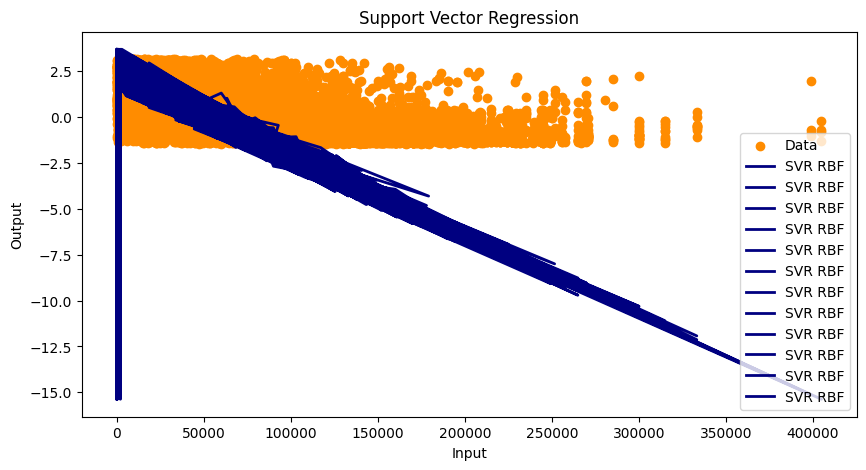

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(X['milage'], y, color='darkorange', label='Data')
plt.plot(X_test, y_pred, color='navy', lw=2, label='SVR RBF')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

## Recurrent neural network

Epoch 1/200
2578/2578 [==============================] - 12s 4ms/step - loss: 0.9661 - accuracy: 0.0000e+00 - val_loss: 0.9178 - val_accuracy: 0.0000e+00
Epoch 2/200
2578/2578 [==============================] - 10s 4ms/step - loss: 0.9260 - accuracy: 0.0000e+00 - val_loss: 0.9119 - val_accuracy: 0.0000e+00
Epoch 3/200
2578/2578 [==============================] - 11s 4ms/step - loss: 0.9192 - accuracy: 0.0000e+00 - val_loss: 0.9029 - val_accuracy: 0.0000e+00
Epoch 4/200
2578/2578 [==============================] - 9s 4ms/step - loss: 0.9093 - accuracy: 0.0000e+00 - val_loss: 0.9033 - val_accuracy: 0.0000e+00
Epoch 5/200
2578/2578 [==============================] - 9s 3ms/step - loss: 0.9034 - accuracy: 0.0000e+00 - val_loss: 0.9150 - val_accuracy: 0.0000e+00
Epoch 6/200
2578/2578 [==============================] - 12s 5ms/step - loss: 0.8983 - accuracy: 0.0000e+00 - val_loss: 0.9036 - val_accuracy: 0.0000e+00
Epoch 7/200
2578/2578 [==============================] - 11s 4ms/step - loss: 

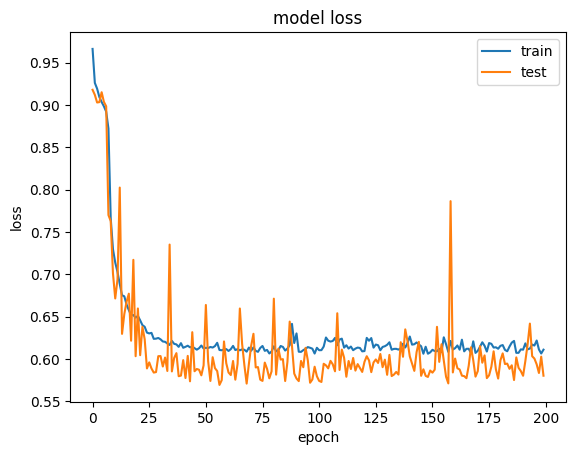

In [ ]:
tf.random.set_seed(42)
x = X_train.values.tolist()
# define the model architecture
model = Sequential()
model.add(SimpleRNN(32, input_shape=(12, 1)))
model.add(Dense(128, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1))
# compile the model
model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
# train the model
H2 = model.fit(np.array(x), y_train.values, batch_size=16, epochs=200 , validation_data=(X_test, y_test)) # , validation_split = 0.2

plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5801097750663757
Test accuracy: 0.0


## Light Gradient-Boosting Machine

In [ ]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt', #gbdt
    'objective': 'regression',
    'metric': 'mse',
    'n_estimators': 100000,
    'learning_rate': 0.05,
}

LGBmodel = lgb.LGBMRegressor(**params)
LGBmodel.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 41247, number of used features: 12
[LightGBM] [Info] Start training from score 0.004815
Training until validation scores don't improve for 100 rounds
[10]	training's l2: 0.607299	valid_1's l2: 0.603729
[20]	training's l2: 0.456978	valid_1's l2: 0.45421
[30]	training's l2: 0.3969	valid_1's l2: 0.394655
[40]	training's l2: 0.370279	valid_1's l2: 0.36901
[50]	training's l2: 0.35661	valid_1's l2: 0.357045
[60]	training's l2: 0.348403	valid_1's l2: 0.350236
[70]	training's l2: 0.34264	valid_1's l2: 0.346334
[80]	training's l2: 0.338637	valid_1's l2: 0.344078
[90]	training's l2: 0.335112	valid_1's l2: 0.342538
[100]	training's l2: 0.331915	valid_1's l2: 0.341256
[110]	training's 

LGBMRegressor(learning_rate=0.05, metric='mse', n_estimators=100000,
              objective='regression')

In [ ]:
y_pred = LGBmodel.predict(X_test)

MSE = np.mean(np.square(y_test - y_pred))
MSE

0.3363044322503269

# Exporting results

Preparing the test dataset by performing the same data cleaning steps that were done on the training dataset.

In [ ]:
test_clean = pd.read_csv('test.csv')

In [ ]:
test_clean

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
36178,90451,GMC,Yukon Denali,2019,4500,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gray,Black,None reported,Yes
36179,90452,Chevrolet,Silverado 1500 Z71 Extended Cab,2004,185000,Gasoline,295.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Red,Gray,At least 1 accident or damage reported,Yes
36180,90453,Toyota,Corolla LE,2011,116000,Gasoline,132.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Beige,Gray,None reported,Yes
36181,90454,Lincoln,Navigator Reserve,2019,39000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Orange,None reported,Yes


In [ ]:
test_clean.drop(['id','clean_title'], axis=1, inplace=True)
test_clean.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported
1,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported
2,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported
3,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported
4,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported


In [ ]:
test_clean['accident']=test_clean['accident'].replace(['None reported' , 'At least 1 accident or damage reported'],[0,1])
test_clean['accident'].astype(int)

0        0
1        0
2        0
3        1
4        1
        ..
36178    0
36179    1
36180    0
36181    0
36182    1
Name: accident, Length: 36183, dtype: int64

In [ ]:
test_clean["int_col"]=test_clean["int_col"].replace("-",test_clean["int_col"].mode()[0])
test_clean["int_col"]=test_clean["int_col"].replace("not supported",test_clean["int_col"].mode()[0])
test_clean["int_col"]

0         Beige
1         Black
2         White
3         White
4         Black
          ...  
36178     Black
36179      Gray
36180      Gray
36181    Orange
36182     Black
Name: int_col, Length: 36183, dtype: object

In [ ]:
test_clean["transmission"] = test_clean["transmission"].replace("–",np.nan)

In [ ]:
test_clean["fuel_type"] = test_clean["fuel_type"].replace("–",np.nan)

In [ ]:
test_clean["engine"] = test_clean["engine"].replace("–",np.nan)

In [ ]:
test_clean["ext_col"] = test_clean["ext_col"].replace("–",np.nan)

In [ ]:
test_clean.dropna(axis=0)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,0
1,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,0
2,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,0
3,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,1
4,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,1
...,...,...,...,...,...,...,...,...,...,...
36178,GMC,Yukon Denali,2019,4500,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gray,Black,0
36179,Chevrolet,Silverado 1500 Z71 Extended Cab,2004,185000,Gasoline,295.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Red,Gray,1
36180,Toyota,Corolla LE,2011,116000,Gasoline,132.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Beige,Gray,0
36181,Lincoln,Navigator Reserve,2019,39000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Orange,0


In [ ]:
def extract_cylinders(description):
    pattern1 = r'\b(\d+)\scylinder\b'
    pattern2 = r'(\d+)\s[Vv]\b'
    pattern3 = r'[Vv]\s*(\d+)\b'
    match1 = re.search(pattern1, description, re.IGNORECASE)
    match2 = re.search(pattern2, description, re.IGNORECASE)
    match3 = re.search(pattern3, description, re.IGNORECASE)
    if match1:
        return int(match1.group(1))
    if match2:
        return int(match2.group(1))
    if match3:
        return int(match3.group(1))

    return 0


hp=test_clean['engine'].astype(str).apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
liters=test_clean['engine'].astype(str).apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')
cylinder=test_clean['engine'].astype(str).apply(extract_cylinders)

test_clean['HP']=hp
test_clean['liters']=liters
test_clean['cylinders']=cylinder
test_clean.drop(['engine'], axis=1, inplace=True)
test_clean.head(5)

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,HP,liters,cylinders
0,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,A/T,White,Beige,0,302.0,3.5,6
1,Lexus,RX 350 Base,2015,128032,Gasoline,8-Speed A/T,Silver,Black,0,275.0,3.5,6
2,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,7-Speed A/T,Blue,White,0,241.0,2.0,4
3,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,Transmission w/Dual Shift Mode,White,White,1,518.0,5.0,8
4,BMW,X6 xDrive40i,2020,90000,Gasoline,8-Speed A/T,White,Black,1,335.0,3.0,6


In [ ]:
test_clean["HP"]=test_clean["HP"].fillna(test_clean['HP'].mean())
test_clean["liters"]=test_clean["liters"].fillna(test_clean['liters'].mean())
test_clean.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       197
transmission      3
ext_col          27
int_col           0
accident          0
HP                0
liters            0
cylinders         0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

test_clean['brand'] = labelEncoder.fit_transform(test_clean['brand'])
test_clean['model'] = labelEncoder.fit_transform(test_clean['model'])
test_clean['fuel_type'] = labelEncoder.fit_transform(test_clean['fuel_type'])
test_clean['transmission'] = labelEncoder.fit_transform(test_clean['transmission'])
test_clean['ext_col'] = labelEncoder.fit_transform(test_clean['ext_col'])
test_clean['int_col'] = labelEncoder.fit_transform(test_clean['int_col'])

In [ ]:
test_df = pd.read_csv('test.csv')
columns_to_drop = ['brand','model','model_year','milage','fuel_type','engine','ext_col','int_col','accident','clean_title','transmission']
test_df = test_df.drop(columns_to_drop, axis=1)
test_df = pd.DataFrame(test_df)

In [ ]:
test_df.head(5)

,id
0,54273
1,54274
2,54275
3,54276
4,54277


The predictions using the RNN model

In [ ]:
dataset_clean = tf.data.Dataset.from_tensor_slices(dict(test_clean))
pred = model.predict(test_clean)

1131/1131 [==============================] - 2s 2ms/step


In [ ]:
test_df['price'] = pred

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_RNN.csv',index = False)

The predictions using the SVR model

In [ ]:
y_predict = svr_rbf.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_SVR.csv',index = False)

The predictions using the gradient boosting regressor

In [ ]:
y_predict = GBR_model.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_GBR.csv',index = False)

The predicitons using the Linear regression model

In [ ]:
y_predict = lr_model.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_LR.csv',index = False)

The predicitons using the XG boost regressor

In [ ]:
y_predict = XG_model.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_XGB.csv',index = False)

The predictions using Random Forest Regressor

In [ ]:
y_predict = RF_model.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_RF.csv',index = False)

The predicitons using LIGHTGM


In [ ]:
y_predict = LGBmodel.predict(test_clean)

test_df['price'] = y_predict

In [ ]:
test_df *= std
test_df += mean

In [ ]:
copy = pd.read_csv('test.csv')
test_df['id'] = copy['id']

In [ ]:
test_df.to_csv('submission_XG.csv',index = False)